In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics.cluster import adjusted_rand_score, rand_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel
from time import time
import networkx as nx

# import warnings filter
from warnings import simplefilter
# ignore all future warnings

In [2]:
def get_data():
    data = np.loadtxt('./semeion.data', dtype=np.int8)
    return data[:, :256], data[:, 256:]


def one_hot_decode(y: np.array):
    return np.argmax(y, axis=1)


def get_data_transformed():
    data = np.loadtxt('./semeion.data', dtype=np.int8)
    return data[:, :256], one_hot_decode(data[:, 256:])


In [3]:
# fake class for no dim. red.
class NoDR:
    def __init__(self, n_components):
        pass
    def fit_transform(self, X):
        return X.copy()


In [4]:
simplefilter(action='ignore', category=FutureWarning)
# vector containing the number of clusters
ks = range(5,16)
# vector containing the dimensions for dimensionality reduction
ds = (2,64,128, 256)

In [5]:
def plotimg(row: np.array):
    img = row.reshape((16,16))
    plt.imshow(img)
    plt.show()

In [6]:
def plot2D(X, y, title):
    'Plot first 2 columns and color according to labels'
    plt.scatter(X[:,0], X[:,1], c=y)
    plt.title(title)
    plt.show()
    plt.clf()

In [7]:
def print_rand(y_true, y_pred):
    'Print and return the Rand Indexes'
    ari = adjusted_rand_score(y_true, y_pred)
    ri = rand_score(y_true, y_pred)
    print('adjusted_rand_score', round(ari * 100, 2), '%')
    print('rand_score', round(ri * 100, 2), '%', end='\n\n')
    return ari, ri

In [8]:
class N_Cut():
    def __init__(self, n_clusters):
        self.n_clusters = n_clusters


    def __str__(self):
        return 'NCUT'


    def fit(self, X, verbose=False):
        self.n_samples, self.n_features = X.shape

        A = rbf_kernel(X)

        # set diagonal to 0
        np.fill_diagonal(A, 0.0)
        # print('Adjacency matrix:\n', A)

        G = nx.from_numpy_matrix(A)
        L = nx.normalized_laplacian_matrix(G)
        w = np.linalg.eigvals(L.A)
        if verbose:
         print("Largest eigenvalue:", max(w))
         print("Smallest eigenvalue:", min(w))
         print(f"first k={self.n_clusters} nonzero eigenvalues:", w[1:self.n_clusters+1])

        # find eigen pairs
        w, v = np.linalg.eig(L.A)

        if not abs(w[0]) < 1e-10:
            raise ValueError(f'First eigenvalue is {w[0]}.\nMust be close to zero.')

        # use first k evecs as embedding space
        U = v[:, 1:self.n_clusters+1]

        # fit kmeans on embedding space U
        kmeans = KMeans(n_clusters=self.n_clusters).fit(U)

        self.labels_ = kmeans.labels_

In [9]:
def dimensionality_analysis():
    X, _ = get_data_transformed()
    # for d in np.linspace(start=2, stop=256, num=10, endpoint=True, dtype=int):
    for d in (2,64,128):
        pca = PCA(n_components=d)
        X_transformed = pca.fit_transform(X)
        plt.plot()
        plt.title(f'cumsum of PCA Explained Variance Ratio for dimension={d}')
        plt.xlabel('Component')
        plt.ylabel('EVR')
        plt.scatter(
            np.arange(len(pca.explained_variance_)),
            np.cumsum(pca.explained_variance_ratio_)
        )
        plt.axhline(.66,color='red',linestyle='-')
        plt.axhline(.90,color='red',linestyle='--')
        plt.axhline(.95,color='red',linestyle='-.')
        plt.show()

In [10]:
def LCA_NCUT_testing(p=False):
    '''Results for parametric clustering models'''
    # results will be inserted into a DataFrame
    columns = ('clustering_model', 'dim_red_model', 'd', 'k', 'time', 'ARI', 'RI')
    rows = []

    # read data and split
    X, y = get_data_transformed()
    # loop clusteting model
    for k in ks:
        for d in ds:
            if d != 256:
                embedding_model = PCA
            else:
                embedding_model = NoDR
            start_time = time()
            embedding = embedding_model(n_components=d)  # DR model
            X_transformed = embedding.fit_transform(X)
            model = N_Cut(k)  # clustering model
            model.fit(X_transformed)
            elapsed = time() - start_time
            title = f'Results for {model} on {d}-{embedding_model.__name__} - k={k} ({elapsed:.02f}s)'
            print(title)
            # RI score
            ari, ri = print_rand(y, model.labels_)
            # plot results
            if p: plot2D(X_transformed, model.labels_, title)
            result = (str(model), embedding_model.__name__, d, k, elapsed, ari, ri)
            rows.append(result)
    # save results to file
    df = pd.DataFrame(data=rows, columns=columns)
    print(df)
    df.to_csv('LCA_NCUT_results.csv', index=False)

In [11]:
def results_analysis():
    df = pd.concat([
        #pd.read_csv('MS_results.csv'),
        pd.read_csv('LCA_NCUT_results.csv')
    ])
    dfg_model = df.groupby('clustering_model').mean()[['time','ARI','RI']]
    print('averages by clustering model:')
    print(dfg_model.sort_values('ARI', ascending=False))
    print()

    dfg_k = df.groupby('k').mean()[['time','ARI','RI']]
    print('averages by k:')
    print(dfg_k.sort_values('ARI', ascending=False))
    print()

    dfg_dr = df.groupby('dim_red_model').mean()[['time','ARI','RI']]
    print('averages by DR model:')
    print(dfg_dr.sort_values('ARI', ascending=False))
    print()

    dfg_both = df.groupby(['clustering_model','dim_red_model']).mean()[['time','ARI','RI']]
    print('averages by clustering & DR model:')
    print(dfg_both.sort_values('ARI', ascending=False))
    print()

    print('best ARI achieved by:')
    print(df.sort_values('ARI', ascending=False).head(3))


In [12]:
def main():
    """Module testing."""



    # Generate sample data
    centers = [[1, 1], [-1, -1], [1, -1], [-1, 1]]
    X, _ = make_blobs(n_samples=1000, centers=centers, cluster_std=0.6)

    m = N_Cut(4)
    m.fit(X)

    plt.scatter(X[:, 0], X[:, 1], c=m.labels_)
    plt.show()



    dimensionality_analysis()
    #MS_testing()
    LCA_NCUT_testing()
    results_analysis()



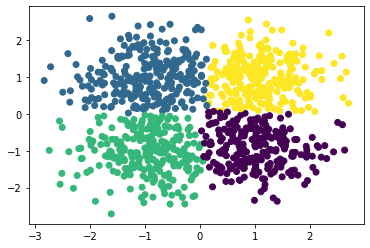

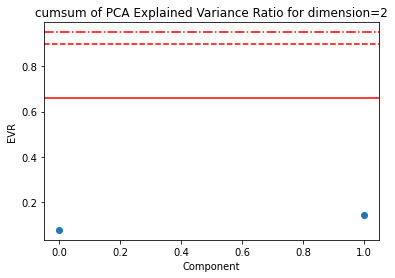

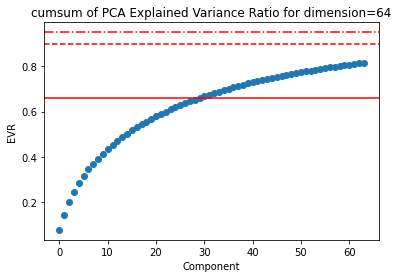

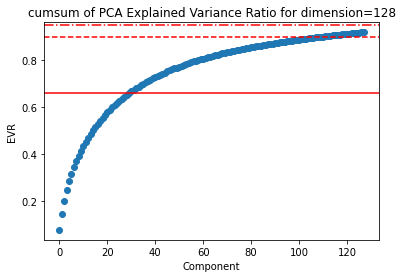

Results for NCUT on 2-PCA - k=5 (13.78s)
adjusted_rand_score 19.93 %
rand_score 76.79 %

Results for NCUT on 64-PCA - k=5 (15.22s)
adjusted_rand_score 24.29 %
rand_score 79.8 %

Results for NCUT on 128-PCA - k=5 (13.85s)
adjusted_rand_score 23.81 %
rand_score 79.69 %

Results for NCUT on 256-NoDR - k=5 (14.34s)
adjusted_rand_score 23.68 %
rand_score 79.7 %

Results for NCUT on 2-PCA - k=6 (13.52s)
adjusted_rand_score 21.28 %
rand_score 79.48 %

Results for NCUT on 64-PCA - k=6 (13.55s)
adjusted_rand_score 28.68 %
rand_score 82.68 %

Results for NCUT on 128-PCA - k=6 (14.17s)
adjusted_rand_score 30.11 %
rand_score 83.3 %

Results for NCUT on 256-NoDR - k=6 (13.63s)
adjusted_rand_score 29.46 %
rand_score 83.12 %

Results for NCUT on 2-PCA - k=7 (13.01s)
adjusted_rand_score 19.54 %
rand_score 78.98 %

Results for NCUT on 64-PCA - k=7 (12.94s)
adjusted_rand_score 33.41 %
rand_score 85.34 %

Results for NCUT on 128-PCA - k=7 (12.61s)
adjusted_rand_score 34.92 %
rand_score 85.7 %

Results fo

In [13]:
if __name__ == '__main__':
    main()